In [91]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate as intg
from scipy import optimize as opt

In [92]:
### Single subspace representations of spin and angular momentum operators
svec = [0.5*np.array([[0.,1.],[1.,0.]],dtype=complex), 0.5*np.array([[0.,-1.j],[1.j,0.]],dtype=complex), 0.5*np.array([[1.,0.],[0.,-1.]],dtype=complex) ]
lvec = [np.sqrt(0.5)*np.array([[0.,1.,0.],[1.,0.,1.],[0.,1.,0.]],dtype=complex),np.sqrt(0.5)*np.array([[0.,-1.j,0.],[1.j,0.,-1.j],[0.,1.j,0.]],dtype=complex),np.array([[1.,0.,0.],[0.,0.,0.],[0.,0.,-1.]],dtype=complex)]

### Kronecker product for single-site spin-angular momentum algebra 
svec_op = [np.kron(svec[i],np.eye(3,dtype=complex)) for i in range(3)]
lvec_op = [np.kron(np.eye(2,dtype=complex),lvec[i]) for i in range(3)]

### Single-site identity operator
one6 = np.eye(6,dtype=complex)

### We construct a tensor-product set of operators for two sites 
### We start with the L1.L2 operator
l1 = [np.kron(lvec_op[i],one6) for i in range(3)]
l2 = [np.kron(one6,lvec_op[i]) for i in range(3)]

l1l2 = sum([l1[i]@l2[i] for i in range(3)])

### Now we do the S1.S2 operator
s1 = [np.kron(svec_op[i],one6) for i in range(3)]
s2 = [np.kron(one6,svec_op[i]) for i in range(3)]

s1s2 = sum([s1[i]@s2[i] for i in range(3)])

### Two site identity operator
one36 = np.kron(one6,one6)

### Now we construct the various projection operators for the angular momentum
proj_s = 1./3.*( l1l2@l1l2 - one36 )
proj_p = one36 - 0.5*l1l2 - 0.5*l1l2@l1l2
proj_d = 1./3.*one36 + 0.5*l1l2 + 1./6.*l1l2@l1l2

### Spin parity operator S1.S2 + 1/4
sparity = s1s2 + 1./4.*one36


In [93]:
### Given an overall superexchange J0 and Hund's coupling ratio eta this returns the different superexchange interaction strengths
def jmultiplet(j0,eta):
    return j0/(1.+2.*eta), j0/(1.-3.*eta), j0/(1.-eta)

### Returns spin-orbit hamiltonian for pair of sites
def hsoc(soc):
    return soc*sum([s1[i]@l1[i] + s2[i]@l2[i] for i in range(3)])

### Returns crystal field hamiltonian for pair of sites
### Accepts three eigevalues for crystal field parameters (one is redundant)
def hcf(cfs1,cfs2):
    return sum([ 0.5*cfs1[i]*l1[i]@l1[i]  + 0.5*cfs2[i]*l2[i]@l2[i] for i in range(3)])

### Returns superexchange Hamiltonian for pair of sites given superexchange parameters J0 and eta
### z is coordination number of the lattice (we assume default of 6)
def hsex(j0,eta,z=6):
    js,jp,jd = jmultiplet(j0,eta)
    
    jop = js * proj_s - jp*proj_p + jd*proj_d
    kop = -js*proj_s - jp*proj_p - jd*proj_d
    
    return z*sparity@jop + 0.5*z*kop

### Returns total Hamiltonian 
def ham(j0,eta,cfs1,cfs2,soc,z=6):
    return hsex(j0,eta,z)+hcf(cfs1,cfs2)+hsoc(soc)
    

In [118]:
### This will make a variational wavefunction in terms of angle parameters
### It returns the tensor product wavefunction for the A and B sites 
### The ansatz is a mean-field product state
### The parameters are passed as ps, a combined list for both sublattices
def product_ansatz_angles(ps):
    
    ### p is a list of 2x(5 + 5) = 20 parameters (5 phases and 5 amplitudes)
    ### First we split in to the two sublattices
    p = [ ps[:10],ps[10:] ]
    
    ### For each site we use the following for coefficients
    ### p[0:5] are amplitude angles and p[5:10] are phase angles
    ### p[0] is restricted to [0,pi)
    psi = [ np.array([
        np.cos(p[i][0]), 
        np.sin(p[i][0])*np.cos(p[i][1])*np.exp(1.j*p[i][5]),
        np.sin(p[i][0])*np.sin(p[i][1])*np.cos(p[i][2])*np.exp(1.j*p[i][6]),
        np.sin(p[i][0])*np.sin(p[i][1])*np.sin(p[i][2])*np.cos(p[i][3])*np.exp(1.j*p[i][7]),
        np.sin(p[i][0])*np.sin(p[i][1])*np.sin(p[i][2])*np.sin(p[i][3])*np.cos(p[i][4])*np.exp(1.j*p[i][8]),
        np.sin(p[i][0])*np.sin(p[i][1])*np.sin(p[i][2])*np.sin(p[i][3])*np.sin(p[i][4])*np.exp(1.j*p[i][9])
    ]) for i in range(2) ]

    return np.kron(psi[0],psi[1])

def mean_energy_angles(ps,h):
    wf = product_ansatz_angles(ps)
    
    return np.conjugate(wf)@h@wf

def find_gs_angles(h):
    ps0 = np.random.ranf(20)*np.pi
    x0 = product_ansatz_angles(ps0)
    
    f = lambda x: mean_energy_angles(x,h)
    
    niter = 50
    
    res = opt.basinhopping(f,x0,niter)
    
    return res


### Here we will generate ansatz by specifying wavefunction amplitudes and then normalizing only in the energy evaluation
### This will explore parameter space in a more unbiased way
### This will make a variational wavefunction in terms of angle parameters
### It returns the tensor product wavefunction for the A and B sites 
### The ansatz is a mean-field product state
### The parameters are passed as ps, a combined list for both sublattices
def product_ansatz(z):
    
    ### z is a list of 12 complex parameters 
    ### First we split in to the two sublattices
    zs = [ z[:6],z[6:] ]
    
    ### We now simply need to normalize the site wavefunctions
    psis = [ zs[i]/np.sqrt(np.conjugate(zs[i])@zs[i]) for i in range(2)]

    psi = np.kron(psis[0],psis[1])
    
    return psi 

def randomWF():
    ### Returns a random product state wavefunction
    z = np.random.ranf(12) + np.random.ranf(12)*1.j

    return product_ansatz(z)

def mean_energy(z,h):
    wf = product_ansatz(z)
    
    return np.real(np.conjugate(wf)@h@wf)

def find_gs(h):
    x0 = np.random.ranf(12) + 1.j*np.random.ranf(12)
    
    f = lambda x: mean_energy(x,h)
    
    niter = 200
    
    res = opt.basinhopping(f,x0,niter)
    
    return res

def mean_mags(z):
    wf = product_ansatz(z)
    
    m1 = np.array([ np.real(np.conjugate(wf)@s1[i]@wf) for i in range(3) ])
    m2 = np.array([ np.real(np.conjugate(wf)@s2[i]@wf) for i in range(3) ])
    
    return m1,m2


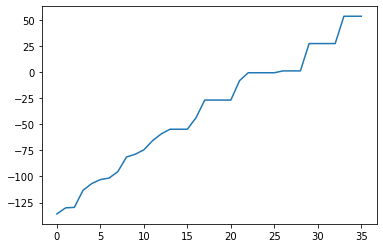

/usr/lib/python3/dist-packages/scipy/optimize/_differentiable_functions.py:107: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x0).astype(float)
/usr/lib/python3/dist-packages/scipy/optimize/_differentiable_functions.py:243: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:155: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,


-89.51285402628952
(array([-0.39497658, -0.14275611,  0.12424758]), array([ 0.42915574, -0.06611222, -0.10071218]))


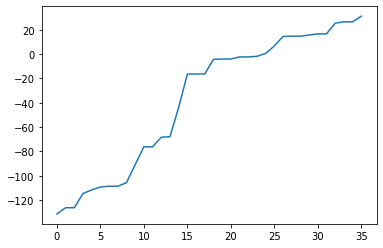

/usr/lib/python3/dist-packages/scipy/optimize/_differentiable_functions.py:107: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x0).astype(float)
/usr/lib/python3/dist-packages/scipy/optimize/_differentiable_functions.py:243: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/usr/lib/python3/dist-packages/scipy/optimize/_linesearch.py:155: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,


-105.45697521435861
(array([-0.47730734, -0.09527578,  0.00252938]), array([-0.44455946, -0.04535978, -0.00592686]))


In [121]:
j0 = 10.### meV
eta = 0.14 ### J_H/U
cf1s = np.array([-50.,50.,0.]) ### meV
cf2s = np.array([-50.,50.,0.]) ### meV
soc = 12.### meV

h = ham(j0,eta,cf1s,cf2s,soc)

plt.plot(np.linalg.eigh(h)[0])
plt.show()

gs = find_gs(h)
print(gs.fun)
print(mean_mags(gs.x))

j0 = 10.### meV
eta = 0.14 ### J_H/U
cf1s = np.array([-50.,50.,0.]) ### meV
cf2s = -np.array([-50.,50.,0.]) ### meV
soc = 12.### meV

h = ham(j0,eta,cf1s,cf2s,soc)

plt.plot(np.linalg.eigh(h)[0])
plt.show()

gs = find_gs(h)
print(gs.fun)
print(mean_mags(gs.x))
